# This file is for generate new images from the original images with AutoEncoder.

## Import the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
from torchvision.utils import save_image
from pytorch_fid import fid_score
import time
import os
import re



device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

## Get the data

In [2]:
train_dataset_path = 'data-students/TRAIN/'

IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

## Load the data

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),   # Redimensiona todas as imagens para 75x75 pixels
    transforms.ToTensor()         # Converte as imagens para tensores do PyTorch
])

full_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

data_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


## Show the data

In [4]:
# get how many images we have for each class

traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path)
print("Classes encontradas:", traffic_signals_dataset.classes)

class_count_true = {}

for _, label in traffic_signals_dataset:
    
    if label not in class_count_true:
        class_count_true[label] = 0
        
    class_count_true[label] += 1
    
print(class_count_true)

Classes encontradas: ['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
{0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


## AutoEncoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, color_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(color_channels, 32, kernel_size=3, stride=1, padding=1),  # 75x75
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 38x38
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 19x19
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 38x38
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),  # 75x75
            nn.ReLU(),
            nn.ConvTranspose2d(32, color_channels, kernel_size=3, stride=1, padding=1),  # 75x75
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder().to("cuda" if torch.cuda.is_available() else "cpu")
print(model)
input = torch.randn(1, 3, 75, 75).to("cuda" if torch.cuda.is_available() else "cpu")
output = model(input)
print("Output shape:", output.shape)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)
Output shape: torch.Size([1, 3, 75, 75])


## Train the AutoEncoder

Epoch [1/1], Loss: 0.0428
--- 4.890497446060181 seconds ---


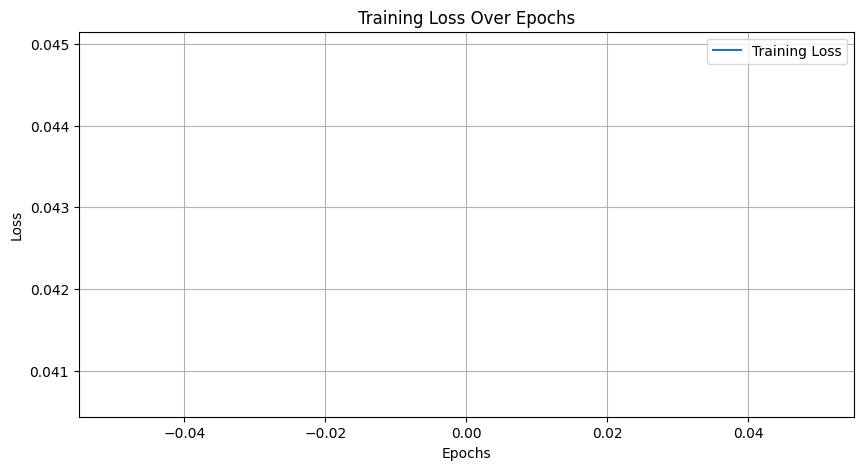

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(color_channels=3)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configurações iniciais
num_epochs = 1
patience = 10
best_loss = float('inf')
trigger_times = 0
losses = []  # Lista para armazenar os valores de perda

# create a time variable to store the time it takes to train the model
start_time = time.time()

for epoch in range(num_epochs):
    for imgs, labels in data_loader:  # Aqui você separa as imagens dos labels
        imgs = imgs.to(device)  # Apenas as imagens são enviadas para o dispositivo

        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Armazenando o valor da perda
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Early stopping logic
    if loss.item() < best_loss:
        best_loss = loss.item()
        trigger_times = 0
    else:
        trigger_times += 1
        print('Early stopping counter: %d of %d' % (trigger_times, patience))
        if trigger_times >= patience:
            print('Early stopping!')
            break

# print the time it took to train the model
print("--- %s seconds ---" % (time.time() - start_time))


# Plotando o gráfico de perdas
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Code for vizualization

In [7]:
def visualize_reconstructions(imgs, reconstructions, num_images=10):
    fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
    for idx in range(min(num_images, imgs.shape[0])):  # Garante que não excedemos o número de imagens disponíveis
        # Mostrar imagem original
        axs[0, idx].imshow(imgs[idx].cpu().detach().numpy().transpose(1, 2, 0))
        axs[0, idx].set_title('Original')
        axs[0, idx].axis('off')

        # Mostrar imagem reconstruída
        axs[1, idx].imshow(reconstructions[idx].cpu().detach().numpy().transpose(1, 2, 0))
        axs[1, idx].set_title('Reconstruída')
        axs[1, idx].axis('off')

    plt.show()



## Function for rename the files

In [8]:
def rename_files(path):
    
    # Lista de nomes de classe reais para mapear
    classes = ['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']

    # Renomeando as subpastas
    for folder_name in os.listdir(path):
        # Extrai o número do nome da pasta tensor(x) usando expressão regular
        match = re.match(r"tensor\((\d+)\)", folder_name)
        if match:
            # O número é o índice na lista de nomes de classes
            index = int(match.group(1))
            new_name = classes[index]  # Mapeia o índice para o nome da classe real

            # Caminho atual (antigo) da pasta
            old_folder_path = os.path.join(path, folder_name)
            # Caminho novo da pasta
            new_folder_path = os.path.join(path, new_name)

            # Renomeia a pasta
            os.rename(old_folder_path, new_folder_path)


## Apply the AutoEncoder to the data

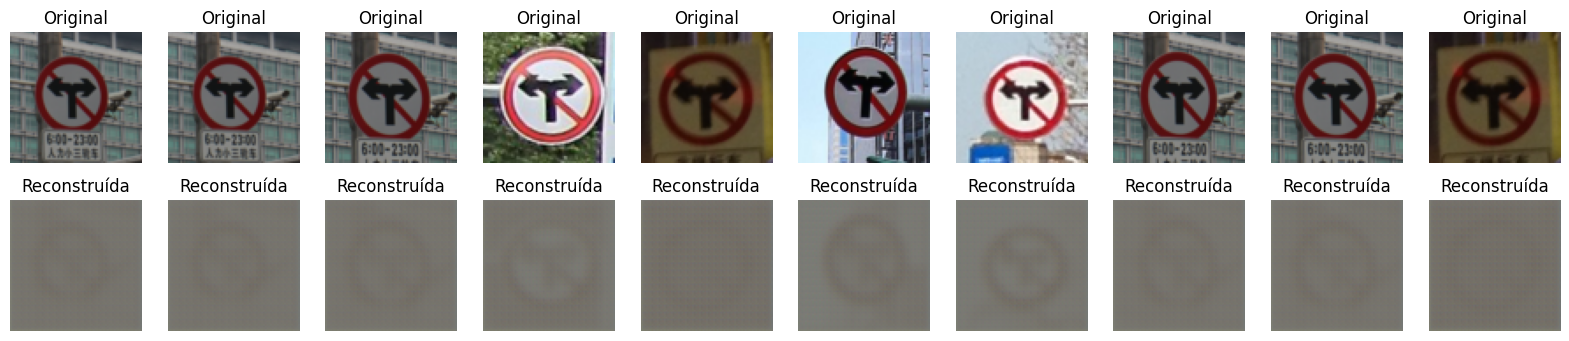

Média do MSE: 0.04141443491809898
Média do SSIM: 0.29679450061586166
Renomeou 'rebuild\tensor(0)' para 'rebuild\12'
Renomeou 'rebuild\tensor(1)' para 'rebuild\13'
Renomeou 'rebuild\tensor(2)' para 'rebuild\24'
Renomeou 'rebuild\tensor(3)' para 'rebuild\38'
Renomeou 'rebuild\tensor(4)' para 'rebuild\39'
Renomeou 'rebuild\tensor(5)' para 'rebuild\44'
Renomeou 'rebuild\tensor(6)' para 'rebuild\46'
Renomeou 'rebuild\tensor(7)' para 'rebuild\49'
Renomeou 'rebuild\tensor(8)' para 'rebuild\50'
Renomeou 'rebuild\tensor(9)' para 'rebuild\6'
torch.Size([21, 3, 75, 75])
torch.Size([21, 3, 75, 75])
Classes encontradas: ['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
Contagem de imagens por classe nas verdadeiras: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}
Contagem de imagens por classe nas reconstruções: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


In [9]:
# Definindo o caminho para salvar as imagens reconstruídas
recon_images_path = 'rebuild'
os.makedirs(recon_images_path, exist_ok=True)

ssim_values = []

mse_loss = nn.MSELoss()
mse_values = []

model.eval()
with torch.no_grad():
    for i, (imgs, labels) in enumerate(data_loader):  # Atenção ao incluir labels aqui
        imgs = imgs.to(device)
        reconstructions = model(imgs)

        # Salvando as imagens reconstruídas organizadas por classe
        for j, (recon, label) in enumerate(zip(reconstructions, labels)):
            class_folder = os.path.join(recon_images_path, str(label))  # Cria um caminho de pasta baseado no rótulo
            os.makedirs(class_folder, exist_ok=True)  # Cria a pasta se não existir
            save_image(recon, os.path.join(class_folder, f'recon_{i}_{j}.png'))  # Salva a imagem na pasta apropriada
            
            
        mse = mse_loss(reconstructions, imgs)
        mse_values.append(mse.item())
        
        current_ssim = ssim(imgs, reconstructions, data_range=1.0, size_average=True)
        ssim_values.append(current_ssim.item())
        
        if i == 0:
            visualize_reconstructions(imgs, reconstructions, num_images=10)

average_mse = sum(mse_values) / len(mse_values)
average_ssim = sum(ssim_values) / len(ssim_values)
print("Média do MSE:", average_mse)
print("Média do SSIM:", average_ssim)

rename_files(recon_images_path)

print(imgs.size())
print(reconstructions.size())

# get for each class the number of images

# Após salvar as imagens reconstruídas e antes de contar as novas imagens
recon_dataset = datasets.ImageFolder(root=recon_images_path)
print("Classes encontradas:", recon_dataset.classes)

# Redefinir o dicionário class_count para garantir que estamos contando apenas as imagens reconstruídas
class_count = {}

for _, label in recon_dataset:
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1


print("Contagem de imagens por classe nas verdadeiras:", class_count_true)
print("Contagem de imagens por classe nas reconstruções:", class_count)